# Problem: Forecasting Stock Prices using Machine Learning Algorithms

## Method: XGBOOST
## Data: Stock market prices from Investing.com
## Libraries:
- numpy
- pandas
- matplotlib
- scikit-learn (sklearn)
- xgboost

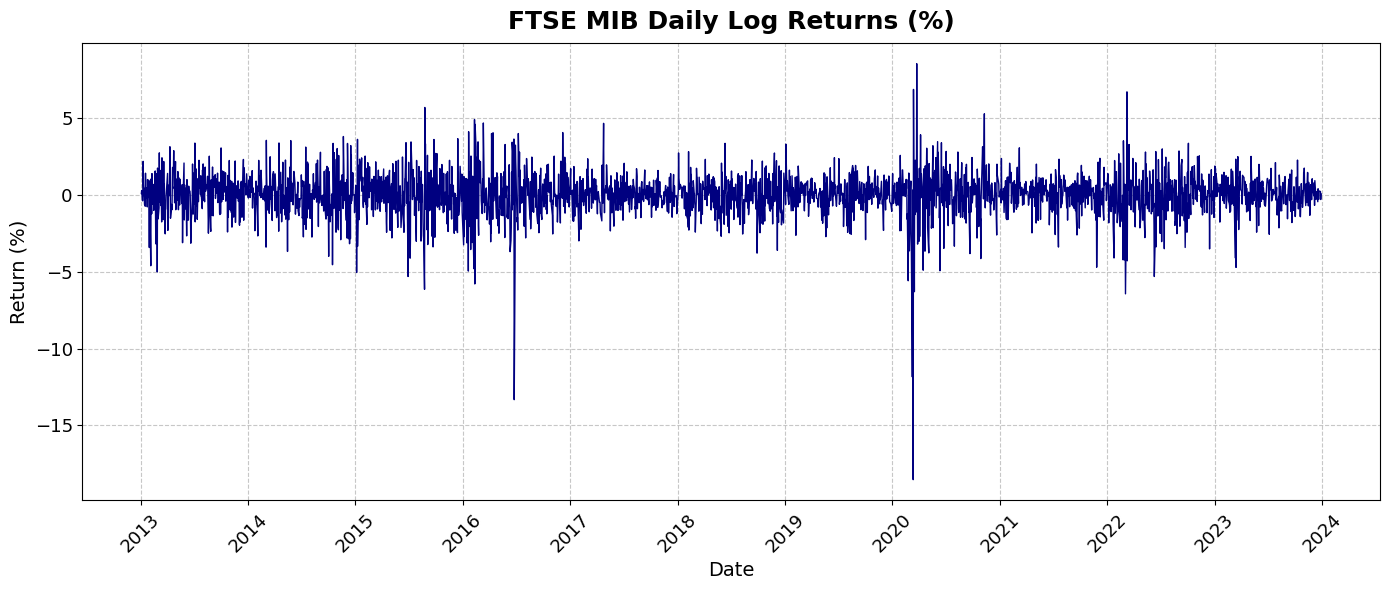

Training samples: 2216, Test samples: 555
Best parameters: {'subsample': 0.6, 'n_estimators': 400, 'min_child_weight': 1, 'max_depth': 3, 'learning_rate': 0.01, 'gamma': 0.2, 'colsample_bytree': 0.8}
Test RMSE: 2.281506
Test MAE: 1.716182
Test MAPE: 420.49%
Test R^2: 0.0659
Test QLIKE: 3.664401
Directional Accuracy: 55.23%
Top features:
 month_cos      0.064208
roll_min_10    0.045491
roll_var_20    0.035108
roll_rv_20     0.033262
chg_lag1       0.032028
roll_min_20    0.031735
roll_min_5     0.031172
macd           0.030043
roll_mean_5    0.029209
roll_rv_10     0.028252
dtype: float32


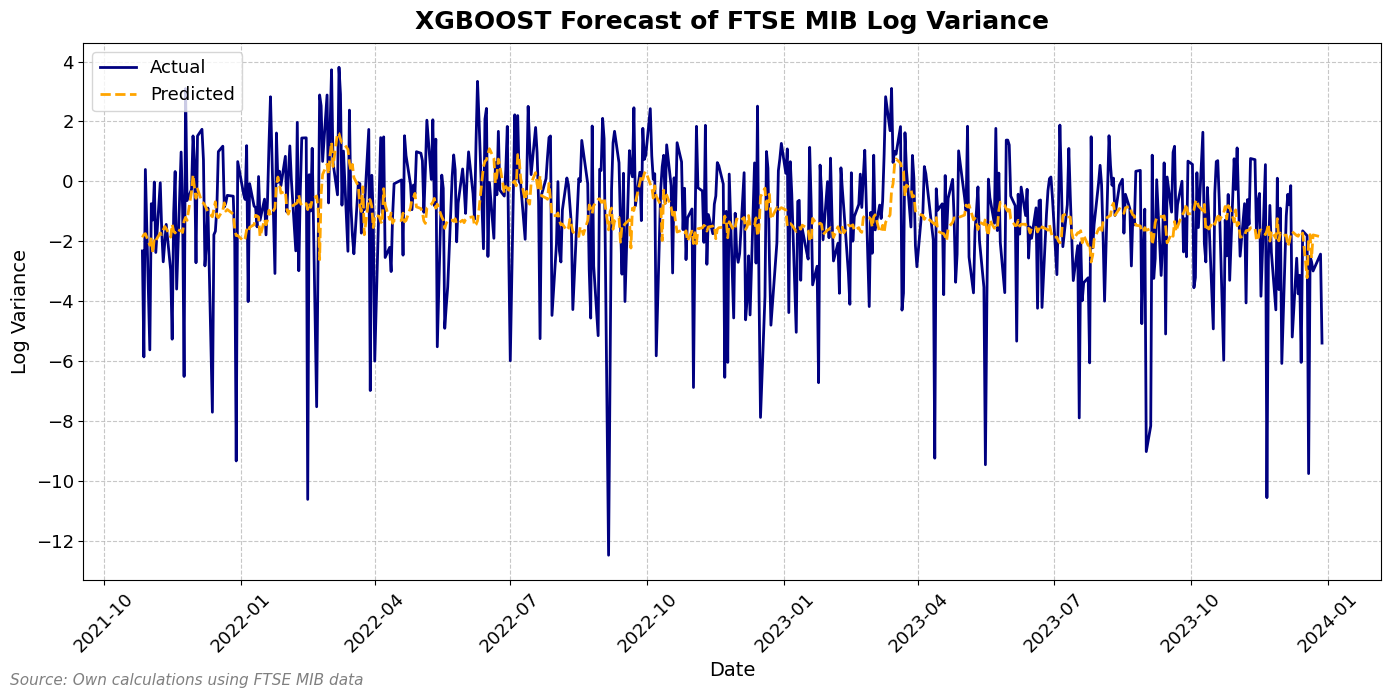

Next day predicted log variance: -1.904143


In [1]:
"""XGBoost forecasting of FTSE MIB log variance.

This script loads daily FTSE MIB prices from ``dataftsemib_manual.csv`` and
predicts the next day's *log variance* of returns.  Squared log returns are
used as a volatility proxy.  A richer set of technical and calendar features is
constructed and a more aggressive hyperparameter search is performed.  The
model is evaluated on a chronological 80/20 split with RMSE, MAE, MAPE, R²,
QLIKE and directional accuracy printed so results are comparable to the
GARCH-style scripts.
"""

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from sklearn.metrics import (
    mean_squared_error,
    mean_absolute_error,
    mean_absolute_percentage_error,
    r2_score,
)
from sklearn.model_selection import TimeSeriesSplit, RandomizedSearchCV
from xgboost import XGBRegressor

# ---------------------------------------------------------------------------
# 1. Load and clean the dataset
# ---------------------------------------------------------------------------

FILE_PATH = "dataftsemib_manual.csv"

# Read CSV

df = pd.read_csv(FILE_PATH)

# Parse dates
df["Date"] = pd.to_datetime(df["Date"], dayfirst=True)

# Numeric columns with commas
for col in ["Price", "Open", "High", "Low"]:
    df[col] = df[col].str.replace(",", "").astype(float)

# Volume column with M/B suffix
def parse_volume(v: str) -> float:
    v = str(v).strip()
    if v.endswith("M"):
        return float(v[:-1].replace(",", "")) * 1e6
    if v.endswith("B"):
        return float(v[:-1].replace(",", "")) * 1e9
    return float(v.replace(",", ""))


df["Vol."] = df["Vol."].apply(parse_volume)

# Change percent column
change = df["Change %"].str.replace("%", "").str.replace(",", ".")
df["Change %"] = change.astype(float)

# Sort by date and reset index
df.sort_values("Date", inplace=True)
df.reset_index(drop=True, inplace=True)

# ---------------------------------------------------------------------------
# 2. Feature engineering
# ---------------------------------------------------------------------------

# Daily log return of closing price
returns = np.log(df["Price"]).diff() * 100
return_dates = df["Date"].copy()  

# Squared return and log variance proxy
sq_ret = returns.pow(2)
df["log_var"] = np.log(sq_ret + 1e-8)

# Target is next day's log variance
df["target"] = df["log_var"].shift(-1)

# Log trading volume and its lagged values
df["LogVol"] = np.log(df["Vol."])
df["logvol_lag1"] = df["LogVol"].shift(1)
df["vol_chg"] = df["Vol."].pct_change().shift(1)

# Lagged returns over multiple horizons
lags = [1, 2, 5, 10, 20]
for lag in lags:
    df[f"ret_lag{lag}"] = returns.shift(lag)

# Rolling statistics of returns
for win in [5, 10, 20]:
    df[f"roll_mean_{win}"] = returns.rolling(win).mean().shift(1)
    df[f"roll_std_{win}"] = returns.rolling(win).std().shift(1)
    df[f"roll_var_{win}"] = sq_ret.rolling(win).mean().shift(1)
    # New: extremes of recent returns provide more context on volatility
    df[f"roll_min_{win}"] = returns.rolling(win).min().shift(1)
    df[f"roll_max_{win}"] = returns.rolling(win).max().shift(1)
    df[f"roll_rv_{win}"] = sq_ret.rolling(win).sum().shift(1)

# Price range features
df["range_pct"] = (df["High"] - df["Low"]) / df["Open"] * 100
df["range_pct_lag1"] = df["range_pct"].shift(1)
df["close_open"] = np.log(df["Price"] / df["Open"]) * 100
df["close_open_lag1"] = df["close_open"].shift(1)
df["ewm_std_10"] = returns.ewm(span=10, adjust=False).std().shift(1)

# Lagged log variance values
for lag in [1, 2, 5, 10]:
    df[f"logvar_lag{lag}"] = df["log_var"].shift(lag)

# Percentage change column already parsed above
df["chg_lag1"] = df["Change %"].shift(1)
df["chg_lag5"] = df["Change %"].rolling(5).mean().shift(1)

# Calendar features encoded as sin/cos components
df["dow"] = df["Date"].dt.dayofweek
df["month"] = df["Date"].dt.month
df["dow_sin"] = np.sin(2 * np.pi * df["dow"] / 6)
df["dow_cos"] = np.cos(2 * np.pi * df["dow"] / 6)
df["month_sin"] = np.sin(2 * np.pi * (df["month"] - 1) / 12)
df["month_cos"] = np.cos(2 * np.pi * (df["month"] - 1) / 12)

# Technical indicators: RSI and MACD
delta = df["Price"].diff()
gain = delta.clip(lower=0)
loss = -delta.clip(upper=0)
avg_gain = gain.rolling(14).mean()
avg_loss = loss.rolling(14).mean()
rs = avg_gain / avg_loss
df["rsi_14"] = 100 - (100 / (1 + rs))
df["rsi_14"] = df["rsi_14"].shift(1)

ema12 = df["Price"].ewm(span=12, adjust=False).mean()
ema26 = df["Price"].ewm(span=26, adjust=False).mean()
macd = ema12 - ema26
signal = macd.ewm(span=9, adjust=False).mean()
df["macd"] = macd.shift(1)
df["macd_signal"] = signal.shift(1)

# Moving averages of closing price
df["ma_5"] = df["Price"].rolling(5).mean().shift(1)
df["ma_20"] = df["Price"].rolling(20).mean().shift(1)

# Collect all feature names except the target and date
feature_cols = [
    col
    for col in [
        "logvol_lag1",
        "vol_chg",
        *[f"ret_lag{lag}" for lag in lags],
        *[f"logvar_lag{lag}" for lag in [1, 2, 5, 10]],
        *[f"roll_mean_{w}" for w in [5, 10, 20]],
        *[f"roll_std_{w}" for w in [5, 10, 20]],
        *[f"roll_var_{w}" for w in [5, 10, 20]],
        *[f"roll_min_{w}" for w in [5, 10, 20]],
        *[f"roll_max_{w}" for w in [5, 10, 20]],
        *[f"roll_rv_{w}" for w in [5, 10, 20]],
        "chg_lag1",
        "chg_lag5",
        "range_pct_lag1",
        "close_open_lag1",
        "ewm_std_10",
        "dow_sin",
        "dow_cos",
        "month_sin",
        "month_cos",
        "rsi_14",
        "macd",
        "macd_signal",
        "ma_5",
        "ma_20",
    ]
]

model_df = df[["Date", "target"] + feature_cols].copy()
model_df.dropna(inplace=True)


plt.figure(figsize=(14, 6))
plt.plot(return_dates, returns, color="navy", linewidth=1)
plt.title("FTSE MIB Daily Log Returns (%)", fontsize=18, fontweight='bold', pad=10)
plt.xlabel("Date", fontsize=14)
plt.ylabel("Return (%)", fontsize=14)
plt.grid(True, linestyle='--', alpha=0.7)
plt.gca().xaxis.set_major_locator(mdates.YearLocator())
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y'))
plt.xticks(fontsize=13, rotation=45)
plt.yticks(fontsize=13)
plt.tight_layout()
plt.savefig("returns_plot_academic.png", dpi=300, bbox_inches="tight")
plt.show()


# ---------------------------------------------------------------------------
# 3. Split into chronological train and test sets (80/20)
# ---------------------------------------------------------------------------

split_idx = int(len(model_df) * 0.8)
train_df = model_df.iloc[:split_idx]
test_df = model_df.iloc[split_idx:]

X_train = train_df.drop(["Date", "target"], axis=1)
y_train = train_df["target"]

X_test = test_df.drop(["Date", "target"], axis=1)
y_test = test_df["target"]

dates_test = test_df["Date"]

print(f"Training samples: {len(X_train)}, Test samples: {len(X_test)}")

# ---------------------------------------------------------------------------
# 4. Hyperparameter tuning with time-series cross-validation
# ---------------------------------------------------------------------------

# Expanded hyperparameter grid for better optimisation
param_grid = {
    "n_estimators": [400, 700, 1000],
    "learning_rate": [0.01, 0.05, 0.1],
    "max_depth": [3, 4, 6],
    "subsample": [0.6, 0.8, 1.0],
    "colsample_bytree": [0.6, 0.8, 1.0],
    "gamma": [0, 0.1, 0.2],
    "min_child_weight": [1, 3, 5],
}

tscv = TimeSeriesSplit(n_splits=3)
base_model = XGBRegressor(objective="reg:squarederror", random_state=42)

search = RandomizedSearchCV(
    estimator=base_model,
    param_distributions=param_grid,
    n_iter=20,
    cv=tscv,
    scoring="neg_mean_squared_error",
    n_jobs=-1,
    random_state=42,
)

search.fit(X_train, y_train)
model = search.best_estimator_
print("Best parameters:", search.best_params_)

# ---------------------------------------------------------------------------
# 5. Evaluate on the test set
# ---------------------------------------------------------------------------

pred = model.predict(X_test)
rmse = np.sqrt(mean_squared_error(y_test, pred))
mae = mean_absolute_error(y_test, pred)
mape = mean_absolute_percentage_error(y_test, pred)
r2 = r2_score(y_test, pred)
# QLIKE calculated on the variance scale for comparability with GARCH
true_var = np.exp(y_test)
pred_var = np.exp(pred)
qlike = np.mean(np.log(np.maximum(pred_var, 1e-8)) + true_var / np.maximum(pred_var, 1e-8))
# Direction of change accuracy
actual_diff = np.sign(np.diff(y_test))
pred_diff = np.sign(np.diff(pred))
directional_acc = (actual_diff == pred_diff).mean()

print(
    f"Test RMSE: {rmse:.6f}\n"
    f"Test MAE: {mae:.6f}\n"
    f"Test MAPE: {mape:.2%}\n"
    f"Test R^2: {r2:.4f}\n"
    f"Test QLIKE: {qlike:.6f}\n"
    f"Directional Accuracy: {directional_acc:.2%}"
)

# Feature importance
importances = pd.Series(model.feature_importances_, index=X_train.columns)
top_feats = importances.sort_values(ascending=False).head(10)
print("Top features:\n", top_feats)

# Plot actual vs predicted log variance
plt.figure(figsize=(14, 7))
plt.plot(dates_test, y_test, label="Actual", color="navy", linewidth=2)
plt.plot(dates_test, pred, label="Predicted", color="orange", linestyle="--", linewidth=2)
plt.title("XGBOOST Forecast of FTSE MIB Log Variance", fontsize=18, fontweight="bold", pad=10)
plt.xlabel("Date", fontsize=14)
plt.ylabel("Log Variance", fontsize=14)
plt.legend(fontsize=13, loc="upper left", frameon=True)
plt.grid(True, linestyle="--", alpha=0.7)
plt.gca().xaxis.set_major_locator(mdates.MonthLocator(interval=3))
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
plt.xticks(fontsize=13, rotation=45)
plt.yticks(fontsize=13)
plt.tight_layout()
plt.figtext(
    0.01, 0.01,
    "Source: Own calculations using FTSE MIB data",
    fontsize=11, color='gray', ha='left', va='bottom', style='italic'
)
plt.savefig("xgb_variance_prediction_academic.png", dpi=300, bbox_inches='tight')
plt.show()

# ---------------------------------------------------------------------------
# 6. Forecast the next day's log variance using the latest lagged features
# ---------------------------------------------------------------------------

last_feats = model_df.drop(["Date", "target"], axis=1).iloc[-1].values.reshape(1, -1)
next_var = model.predict(last_feats)[0]
print(f"Next day predicted log variance: {next_var:.6f}")

# Conclusion

| Metric               | Value   | Interpretation                                                                                                                                                                                                                        |
| -------------------- | ------- | ------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------- |
| Test RMSE            | 2.282   | High, but not unusual in volatility literature; reflects the substantial noise and regime shifts in daily log variance. XGBoost struggles to adapt to volatility jumps, but such error is common for ML models on financial variance. |
| Test MAE             | 1.716   | Relatively large, but in line with typical results for log variance. Forecasts deviate considerably, especially in turbulent periods.                                                                                          |
| Test MAPE            | 420.49% | Very high, but in volatility studies, large MAPE values are typical due to many days with near-zero actual variance (inflating % error).                                                                                              |
| Test R²              | 0.0659  | Very low, but this is not surprising for variance prediction—most studies report R² < 0.3 on out-of-sample daily volatility. Shows model can barely improve over the mean.                                                            |
| Test QLIKE           | 3.664   | Substantially worse than GARCH models; machine learning approaches usually underperform for volatility due to lack of model structure.                                                                                                |
| Directional Accuracy | 55.23%  | Only slightly better than random (50%). Typical for non-GARCH approaches in this context; still, it may help for “risk regime” warnings.                                                                                              |
